First we go through the image reading and knowing about it dimensions

In [50]:
import imageio 
img_arr = imageio.imread('/Users/nshravanreddy/Downloads/Dark.jpeg')
img_arr.shape

/var/folders/3l/0wyx0km56b13vml1rgzhch080000gn/T/ipykernel_3246/3926233812.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_arr = imageio.imread('/Users/nshravanreddy/Downloads/Dark.jpeg')


(148, 204, 3)

(Height,width,Dimension) 
Dimensions 1 , 2 , 3

In [42]:
import torch
import torch.nn as nn
conv=nn.Conv2d(3,1,kernel_size=3)
m=conv
m

Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1))

In [43]:
m.weight.shape,m.bias.shape

(torch.Size([1, 3, 3, 3]), torch.Size([1]))

weight is [no_out,no_int,kernalsize {=(3,3)}]
Bias is the no_out

In [44]:
transform=transforms.ToTensor()
img_arr_transformed=transform(img_arr)
img_arr_transformed.shape

torch.Size([3, 148, 204])

In [48]:
m(img_arr_transformed.unsqueeze(0)).shape,m.weight.shape,m.bias.shape

(torch.Size([1, 1, 146, 202]), torch.Size([1, 3, 3, 3]), torch.Size([1]))

#### output is (batchsize,no of outout filters,height,width)
### Height= (H-Kernal+2*Padding)/Stripe+1
### Width= (W-Kernal+2*Padding)/Stripe+1 Default Stripe is 1


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 

batch_size=100

learning_rate=0.01
epochs=5


In [10]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
from torchvision import datasets, transforms

# MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


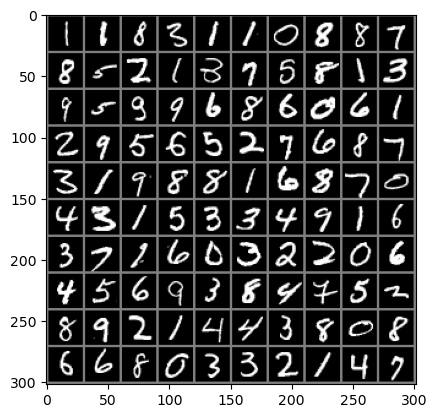

In [12]:
from torchvision.utils import make_grid
def show_images(img):
    img=img/2 + 0.5
    img_numpy=img.numpy()
    plt.imshow(np.transpose(img_numpy,(1,2,0)))
    plt.show()

images, _=next(iter(train_loader))
show_images(make_grid(images,nrow=10))

In [74]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.convolutions = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.convolutions(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [75]:
model=CNN()

In [76]:
cross_entropy=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

In [80]:
train_losses = []
test_losses = []

for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        x = Variable(images)
        y = Variable(labels)
        y_pred = model(x)
        loss = cross_entropy(y_pred, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = cross_entropy(output, labels)
            test_loss += loss.item()

    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    test_loss = test_loss/len(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"epoch {epoch+1}: train loss {train_loss}, test loss {test_loss}")

epoch 1: train loss 0.06336921873230797, test loss 0.05857571398417349
epoch 2: train loss 0.057968451128496475, test loss 0.059608142170473
epoch 3: train loss 0.052788190461384756, test loss 0.0481418421593844
epoch 4: train loss 0.05273588663013167, test loss 0.06727861487248447
epoch 5: train loss 0.05390913442626091, test loss 0.07552215103696654


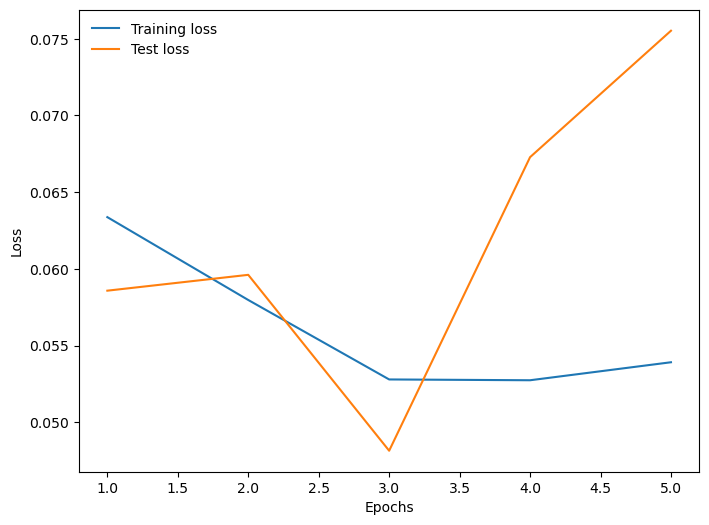

In [81]:
x_values = list(range(1, epochs+1))
plt.figure(figsize=(8., 6.))
plt.plot(x_values, train_losses, label='Training loss');
plt.plot(x_values, test_losses, label='Test loss');
plt.xlabel("Epochs");
plt.ylabel("Loss");
plt.legend(frameon=False);

In [83]:
model.eval()
with torch.no_grad():
    correct,total=0.0, 0.0
    for images,labels in test_loader:
        images, labels=images.to(device),labels.to(device)
        outputs=model(images)
        _, y_pred=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(y_pred ==labels).sum().item()
print("Accuracy: {}%".format(100*correct/total))

Accuracy: 98.08%


We can use Dropout in nonlinear activation function and the linear or convolutional module of the subsequent layer